In [77]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [78]:
train_df = pd.read_csv('/Users/omid/Desktop/KG/Rainfall/files/train.csv')
test_df = pd.read_csv('/Users/omid/Desktop/KG/Rainfall/files/test.csv')

In [79]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [81]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [82]:
test_df['winddirection'] = test_df['winddirection'].fillna(test_df['winddirection'].median())

### bareci outliers

In [83]:
# Let's check your outlier detection
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

# Let's analyze numerical columns
numerical_columns = ['pressure', 'maxtemp', 'temparature', 'mintemp', 
                    'dewpoint', 'humidity', 'cloud', 'sunshine', 
                    'winddirection', 'windspeed']

# Check outliers in training set
outliers_count = detect_outliers(train_df, numerical_columns)

# Print results with percentage
print("Outlier Analysis:")
print("-" * 50)
total_rows = len(train_df)
for col, count in outliers_count.items():
    percentage = (count / total_rows) * 100
    print(f"{col:15} : {count:4d} outliers ({percentage:.2f}%)")

Outlier Analysis:
--------------------------------------------------
pressure        :    4 outliers (0.18%)
maxtemp         :    0 outliers (0.00%)
temparature     :    0 outliers (0.00%)
mintemp         :    1 outliers (0.05%)
dewpoint        :   26 outliers (1.19%)
humidity        :   28 outliers (1.28%)
cloud           :  129 outliers (5.89%)
sunshine        :    0 outliers (0.00%)
winddirection   :    0 outliers (0.00%)
windspeed       :   28 outliers (1.28%)


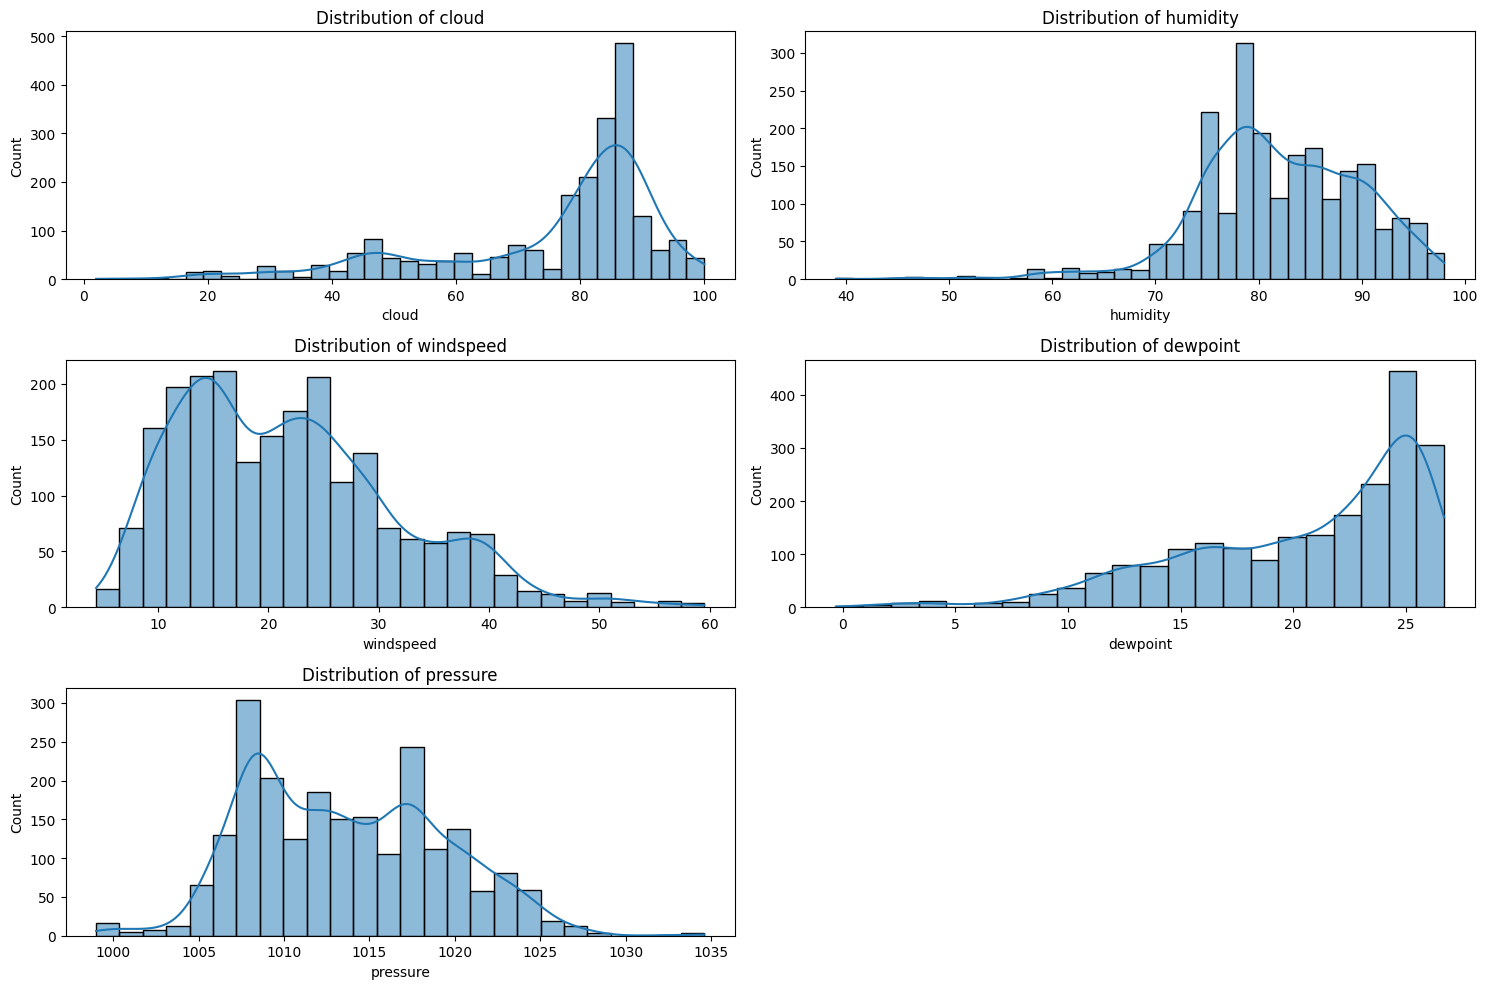

In [84]:
def plot_distributions(df, columns_with_outliers):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns_with_outliers, 1):
        plt.subplot(3, 2, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# فقط ستون‌هایی که outlier دارند را بررسی می‌کنیم
columns_with_outliers = ['cloud', 'humidity', 'windspeed', 'dewpoint', 'pressure']
plot_distributions(train_df, columns_with_outliers)

In [85]:
def handle_outliers_improved(df, columns_config):
    df_clean = df.copy()
    
    for column, method in columns_config.items():
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if method == 'clip':
            # برای متغیرهایی که outlier زیادی ندارند
            df_clean[column] = df_clean[column].clip(lower_bound, upper_bound)
        
        elif method == 'winsorize':
            # برای cloud که outlier زیاد دارد
            df_clean.loc[df_clean[column] < lower_bound, column] = lower_bound
            df_clean.loc[df_clean[column] > upper_bound, column] = upper_bound
        
        elif method == 'mean':
            # جایگزینی با میانگین برای outlierها
            mask = (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
            df_clean.loc[mask, column] = df_clean[column].mean()
    
    return df_clean

In [86]:
columns_config = {
    'cloud': 'winsorize',      # به دلیل تعداد زیاد outlier
    'humidity': 'clip',        # به دلیل اهمیت در پیش‌بینی باران
    'windspeed': 'clip',       # به دلیل اهمیت در پیش‌بینی باران
    'dewpoint': 'clip',        # به دلیل ارتباط با دما و رطوبت
    'pressure': 'mean'         # به دلیل تعداد کم outlier
}

In [87]:
train_df_clean = handle_outliers_improved(train_df, columns_config)
test_df_clean = handle_outliers_improved(test_df, columns_config)

In [88]:
def compare_before_after(original_df, cleaned_df, columns):
    for col in columns:
        print(f"\nColumn: {col}")
        print("Original - Mean: {:.2f}, Std: {:.2f}".format(
            original_df[col].mean(), original_df[col].std()))
        print("Cleaned  - Mean: {:.2f}, Std: {:.2f}".format(
            cleaned_df[col].mean(), cleaned_df[col].std()))

compare_before_after(train_df, train_df_clean, columns_with_outliers)


Column: cloud
Original - Mean: 75.72, Std: 18.03
Cleaned  - Mean: 76.38, Std: 16.34

Column: humidity
Original - Mean: 82.04, Std: 7.80
Cleaned  - Mean: 82.11, Std: 7.54

Column: windspeed
Original - Mean: 21.80, Std: 9.90
Cleaned  - Mean: 21.74, Std: 9.71

Column: dewpoint
Original - Mean: 20.45, Std: 5.29
Cleaned  - Mean: 20.48, Std: 5.22

Column: pressure
Original - Mean: 1013.60, Std: 5.66
Cleaned  - Mean: 1013.56, Std: 5.59


In [89]:
train_df = train_df_clean
test_df = test_df_clean

### done bareci outliers ha 

In [90]:
combine = [train_df, test_df]

In [91]:
test_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.30
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.30
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.90
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,49.25
4,2194,5,1022.2,16.1,13.8,6.4,4.5,68.0,49.0,9.2,20.0,19.40


In [92]:
test_id = test_df['id']

In [93]:
test_id.head()

0    2190
1    2191
2    2192
3    2193
4    2194
Name: id, dtype: int64

In [94]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,60.5,45.0,3.6,40.0,24.8,0


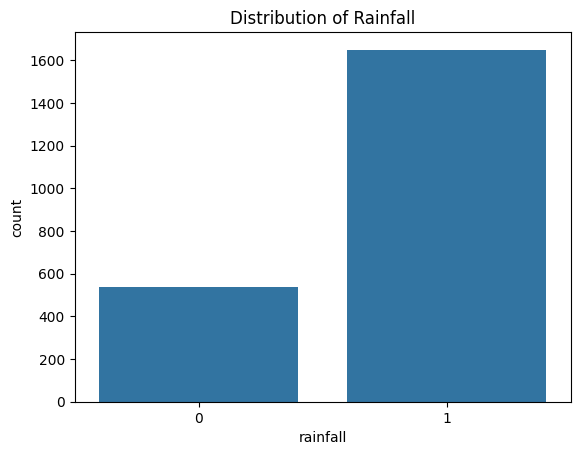

In [95]:
sns.countplot(x=train_df['rainfall'])
plt.title('Distribution of Rainfall')
plt.show()

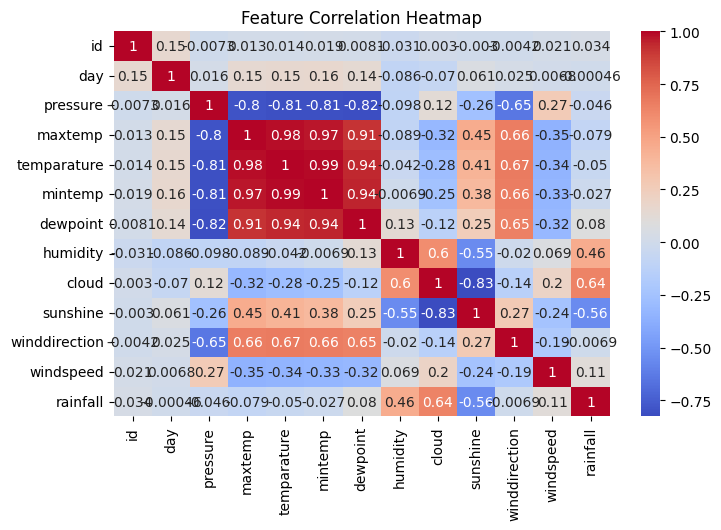

In [96]:
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [97]:
for dataset in combine:
    dataset.drop(['winddirection'], axis=1, inplace=True)

In [98]:
for dataset in combine:
    dataset['humidity_cloud'] = dataset['humidity'] * dataset['cloud']
    dataset['sunshine_ratio'] = dataset['sunshine'] / (dataset['cloud'] + 1)  # +1 baraye ke 0 nashe
    dataset['temp_diff'] = dataset['maxtemp'] - dataset['mintemp']
    dataset['month'] = dataset['day'].apply(lambda x: (x-1) // 30 + 1)
    dataset['season'] = dataset['day'].apply(lambda x: (x % 12 + 3) // 3)
    dataset['is_weekend'] = dataset['day'].apply(lambda x: x % 7 in [5,6])
    dataset['temp_humidity'] = dataset['temparature'] * dataset['humidity']
    dataset['cloud_sunshine'] = dataset['cloud'] * dataset['sunshine']
    dataset['dewpoint_humidity'] = dataset['dewpoint'] * dataset['humidity']

In [99]:
scaler = StandardScaler()
columns_to_scale = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'humidity', 'cloud', 
                    'sunshine', 'windspeed', 'humidity_cloud', 'sunshine_ratio', 'temp_diff','month','season',
                    'is_weekend','temp_humidity','cloud_sunshine','dewpoint_humidity']
for dataset in combine:
    dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])

In [109]:
X = train_df[['temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 
              'humidity_cloud', 'sunshine_ratio']]
Y = train_df['rainfall']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Check accuracy with cleaned data
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy with cleaned data: {accuracy_rf:.4f}")

Random Forest Accuracy with cleaned data: 0.8539


In [102]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
rf_model = grid_search.best_estimator_


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}


In [108]:
#submission = pd.DataFrame({
#       "id": test_id,
#      "rainfall": Y_pred
# })
#submission.to_csv('submission2.csv', index=False)